# Training model to classify images

In [ ]:
# For instance, you will need the smdebug package
!pip install smdebug torch torchvision

In [1]:
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile

In [2]:
role = sagemaker.get_execution_role() 
session = sagemaker.session.Session() 
region = session.boto_region_name
bucket = session.default_bucket()

print(role, session, region, bucket)

arn:aws:iam::256735873794:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole <sagemaker.session.Session object at 0x7f11f5cc4f28> us-east-1 sagemaker-us-east-1-256735873794


## Dataset
The dataset used for this project will be CIFAR10, since this is not a course for learning just CNNs, I will keep it simple and deep more into Sagemaker capabilities.

## Hyperparameter Tuning
Finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
# Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "momentum": ContinuousParameter(0.1, 1),
    "epochs": IntegerParameter(2, 4)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Val set: Average loss: ([0-9\\.]+)" }, {"Name": "test accuracy", "Regex": "Val set: Average loss: [0-9\\.]+, Accuracy: ([0-9\\.]+)% "}]

In [6]:
# Create estimators for your HPs
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [ ]:
tuner.fit(wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [12]:
print(tuner.best_training_job())

pytorch-training-230202-1542-002-75cbd273


In [17]:
# Get the best estimators and the best HPs
best_training_job_name = tuner.best_training_job()

# Get the hyperparameters of the best trained model
training_job_result = session.sagemaker_client.describe_training_job(TrainingJobName=best_training_job_name)
best_hyperparameters = training_job_result['HyperParameters']
best_hyperparameters

{'_tuning_objective_metric': 'average test loss',
 'epochs': '3',
 'learning_rate': '0.003907857318452687',
 'momentum': '0.5778570727535858',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-02-02-15-42-01-129"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-256735873794/pytorch-training-2023-02-02-15-42-01-129/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [4]:
{k: best_hyperparameters[k] for k in hyperparameter_ranges.keys()}

NameError: name 'hyperparameter_ranges' is not defined

In [40]:
best_hyperparameters = {'learning_rate': '0.003907857318452687',
 'momentum': '0.5778570727535858',
 'epochs': '3'}

In [42]:
# Declare rules
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    
#     ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [43]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
    hyperparameters=best_hyperparameters
)

In [44]:
estimator.fit(wait=True)

2023-03-13 16:29:01 Starting - Starting the training job...
2023-03-13 16:29:27 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-03-13 16:30:27 Downloading - Downloading input data
2023-03-13 16:30:27 Training - Downloading the training image...
2023-03-13 16:30:58 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-13 16:31:06,963 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-13 16:31:06,966 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-13 16:31:06,974 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-13 16:31:06,976 sagemaker_pytor

In [19]:
estimator.latest_training_job.name

'pytorch-training-2023-03-13-14-10-42-585'

In [5]:
latest_training_job_name = 'pytorch-training-2023-03-13-14-10-42-585'


In [6]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(latest_training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-256735873794/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-256735873794/pytorch-training-2023-03-13-14-10-42-585/profiler-output


Profiler data from system is available


In [16]:
# Plot profiling report
import IPython

# Replace with your bucket and profiler output path
bucket = "sagemaker-us-east-1-256735873794"
profiler_output_path = f"{latest_training_job_name}/rule-output"

# Initialize the S3 client
s3_client = boto3.client("s3", region_name=region)

# Find the name of the HTML report file
paginator = s3_client.get_paginator("list_objects_v2")
html_report_path = ''
for result in paginator.paginate(Bucket=bucket, Prefix=profiler_output_path):
    for obj in result.get("Contents", []):
#         print(obj)
        if obj["Key"].endswith("profiler-report.html"):
            html_report_path = f"s3://{bucket}/{obj['Key']}"
            print(bucket, obj['Key'], 'profiler-report.html')
            s3_client.download_file(bucket, obj['Key'], 'profiler-report.html')
            break

# Load the HTML report and display it in the notebook
IPython.display.HTML(filename='profiler-report.html')

sagemaker-us-east-1-256735873794 pytorch-training-2023-03-13-14-10-42-585/rule-output/ProfilerReport/profiler-output/profiler-report.html profiler-report.html


In [8]:
# Plot system metrics
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2023-03-16 15:40:43.615 ip-172-16-101-205.ec2.internal:9666 INFO metrics_reader_base.py:134] Getting 18 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


## Model Deploying

In [ ]:
# Deploy the model to an endpoint (Avoided and download it locally to save money)
# predictor = estimator.deploy(
#     initial_instance_count=1,
#     instance_type=instance_type
# )

In [34]:
import tarfile
from train_model import model_fn

# Download file
s3_client.download_file(bucket, f'{latest_training_job_name}/output/model.tar.gz', 'output/model.tar.gz')

# Extract
with tarfile.open('output/model.tar.gz', 'r:gz') as tar:
    tar.extractall(path='output/')
    
# Load model
model = model_fn('output')

In [76]:
import torchvision.transforms as transforms

def predict(raw_image, model):
    # Preprocess image
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])

    image = transform(raw_image).unsqueeze(0)

    # Make prediction
    probabilities = model(image)
    predicted_label = probabilities.argmax()
    
    print(probabilities)
    
    return predicted_label

Files already downloaded and verified
tensor([[ 0.0426, -0.1726,  0.5624, -0.0872, -0.1112,  0.0239, -0.1684,  0.0261,
          0.1186,  0.2709]], grad_fn=<AddmmBackward0>)


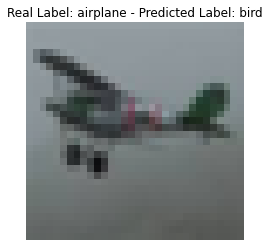

In [77]:
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from random import randrange

# Load CIFAR10 test set
testset = CIFAR10(root='./data', train=False, download=True, transform=None)

# Choose a random image from the test set
idx = randrange(9999)  # Replace with any index from 0 to 9999
raw_image, label = testset[idx]
predicted_label = predict(raw_image, model)


plt.imshow(raw_image)
plt.title(f"Real Label: {testset.classes[label]} - Predicted Label: {testset.classes[predicted_label]}")
plt.axis('off')
plt.show()

In [31]:
# Shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()